In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
#import theano
#import keras.backend as K
%matplotlib inline

## Loading model

In [6]:
from keras.models import load_model
model = load_model("StandAlone/data/modelQ8.h5")

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/home/juillermo/anaconda2/lib/python2.7/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### Visualize model

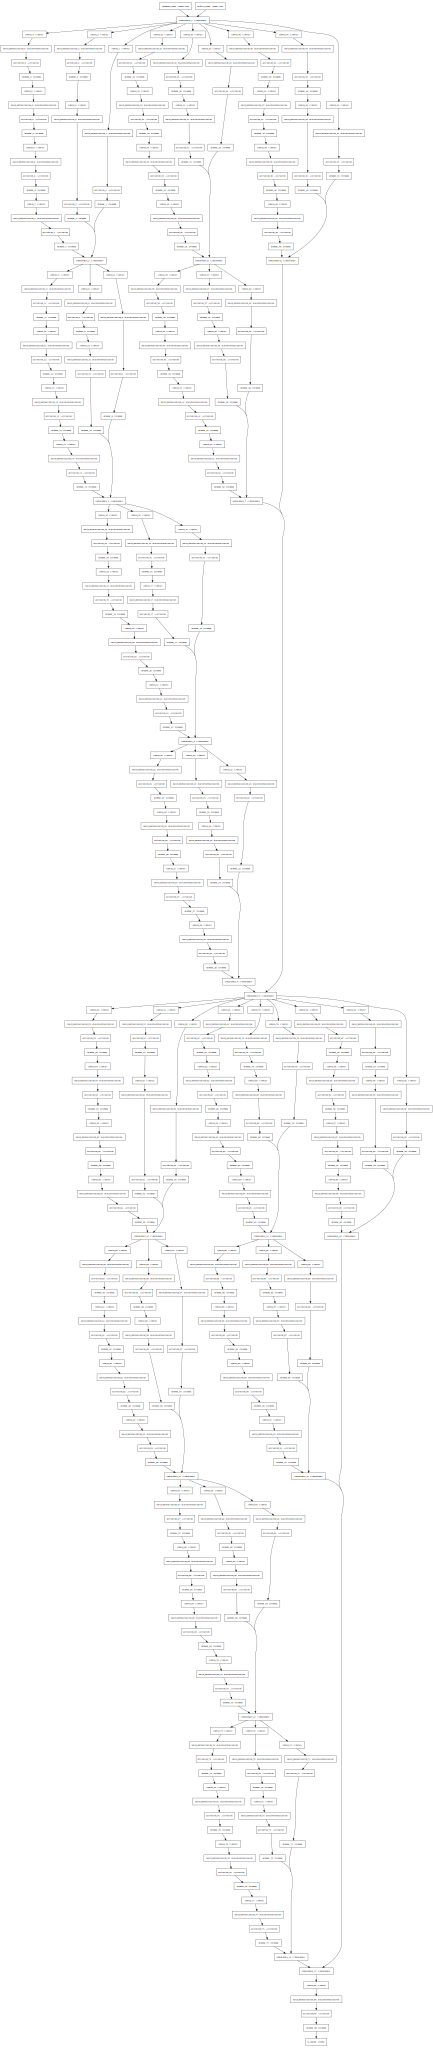

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model.png')

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 700, 21)      0                                            
__________________________________________________________________________________________________
profile_input (InputLayer)      (None, 700, 21)      0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 700, 42)      0           sequence_input[0][0]             
                                                                 profile_input[0][0]              
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 700, 100)     4300        concatenate_1[0][0]              
__________

In [9]:
output = model.get_layer(index=-1)
o_weights = output.get_weights()
print(o_weights[0].shape)
print(o_weights[1].shape)

(455, 9)
(9,)


In [24]:
print type(model.outputs[0])
print model.outputs[0].shape

theano.tensor.var.TensorVariable

In [36]:
conv1d = model.get_layer(index=3)
conv1d.get_config()

{'activation': 'linear',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'data_format': 'channels_last',
 'dilation_rate': (1,),
 'filters': 100,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': u'uniform',
   'mode': u'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'kernel_size': (1,),
 'name': u'conv1d_4',
 'padding': u'same',
 'strides': (1,),
 'trainable': True,
 'use_bias': True}

-------------------------

## Loading data

In [55]:
import test_saliency.saliency as ts
reload(ts)

<module 'test_saliency.saliency' from 'test_saliency/saliency.py'>

In [ ]:
from test_saliency.saliency import load_data
X_am, X_pssm, mask, labels_test = load_data("test_saliency/", 2)

------------------------- 

## Spot best predictions

In [53]:
from StandAlone.bin.executable import convertPredictQ8Result2HumanReadable
from test_saliency.saliency import decode

with open("test_saliency/predictions.pkl", 'rb') as f:
    predictions = pickle.load(f)
print predictions.shape

ssConvertMap = {0: 'C', 1: 'B', 2: 'E', 3: 'G', 4: 'I', 5: 'H', 6: 'S', 7: 'T', 8: ''}
window = 29 # 29 aminoacids per side

for target_class in range(8):
    print "Class ", ssConvertMap[target_class]

    max_target = np.argmax( predictions[:, :, target_class] )
    max_target = np.unravel_index( max_target, predictions.shape[0:2] )
    seq = max_target[0]
    pos = max_target[1]
    
    print "max_target", max_target
    print "value: ", predictions[seq, pos, target_class]

    if pos >= window:
        init = pos - window
    else:
        init = 0
    end = pos + window + 1
    
    gato = decode( X_test_am[seq] )
    print "Aminoacids ", gato[ init:pos ], gato[ pos ], gato[ pos+1:end ]
    perro = convertPredictQ8Result2HumanReadable( predictions[seq] )
    print "Predictions", perro[init:pos], perro[pos], perro[pos+1:end]
    conejo = "".join([ssConvertMap[el] for el in labels_test[seq]])
    print "True labels", conejo[init:pos], conejo[pos], conejo[pos+1:end], "\n"
    
    #gradients = theano.gradient.grad(model.outputs[0][seq,pos,target_class], wrt=[model.inputs[0], model.inputs[1]])
    #get_gradients = K.function(inputs=[model.inputs[0], model.inputs[1], K.learning_phase()], outputs=gradients)
    #inputs = [X_test_am[seq,...], X_test_pssm[seq,...], 0]
    #inputs = [inputs[0][None,...], inputs[1][None,...], inputs[2]]
    #grads = get_gradients(inputs)
    #grads = np.array(grads)
    #plt.plot(np.sum(np.sum(abs(grads[:,0,init:end,:]), axis=2), axis=0)) # Aminoacid importance

(6048, 700, 9)
Class  C
max_target (546, 0)
value:  0.9999999


NameError: name 'X_test_am' is not defined

In [3]:
import pickle
with open("test_saliency/saliencies.pkl", "rb") as f:
    saliencies = pickle.load(f)
    saliencies = np.array(saliencies)
    print("Saliencies shape", saliencies.shape)

('Saliencies shape', (2, 700, 1, 700, 21))


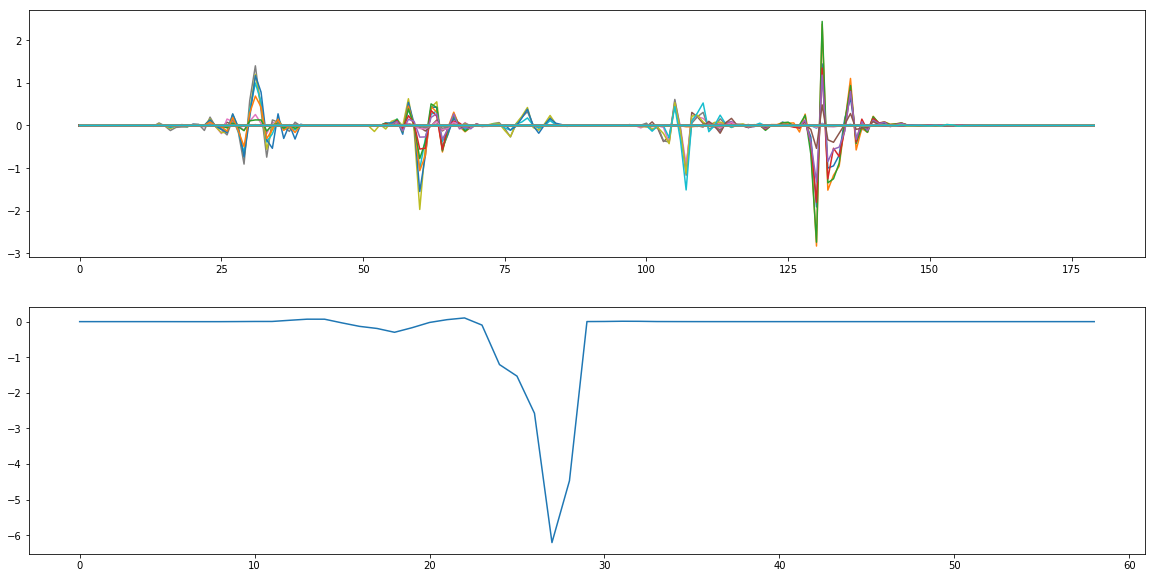

In [77]:
fig, axes = plt.subplots(2,1, figsize=(20,10))

seq = 0
final_pos = 150
window = 29

end = final_pos + window + 1
if end > sum(mask[seq]):
    end = int(sum(mask[seq]))

ax = axes[0]
for pos in range(final_pos):
    ax.plot(np.sum(np.sum(saliencies[:,pos,seq,:end,:], axis=2), axis=0)) # Aminoacid importance


ax = axes[1]
total = np.zeros(2*window + 1)
for pos in range(int(sum(mask[seq]))):
    if pos > window:
        init = pos - window
        total[:window] += np.sum(np.sum(saliencies[:,pos,seq,init:pos,:], axis=2), axis=0)
    elif pos != 0:
        init = window - pos
        total[init:window] += np.sum(np.sum(saliencies[:,pos,seq,0:pos,:], axis=2), axis=0)
        
    total[window] = np.sum(np.sum(saliencies[:,pos,seq,pos,:], axis=1), axis=0)
    
    if pos + window + 1 <= sum(mask[seq]):
        end = pos + window + 1
        total[window+1:] = np.sum(np.sum(saliencies[:,pos,seq,pos+1:end,:], axis=2), axis=0)
    elif pos != int(sum(mask[seq])):
        end = int(sum(mask[seq]))
        total[window+1:-(pos+window+1-end)] = np.sum(np.sum(saliencies[:,pos,seq,pos+1:end,:], axis=2), axis=0)
    
ax.plot(total)

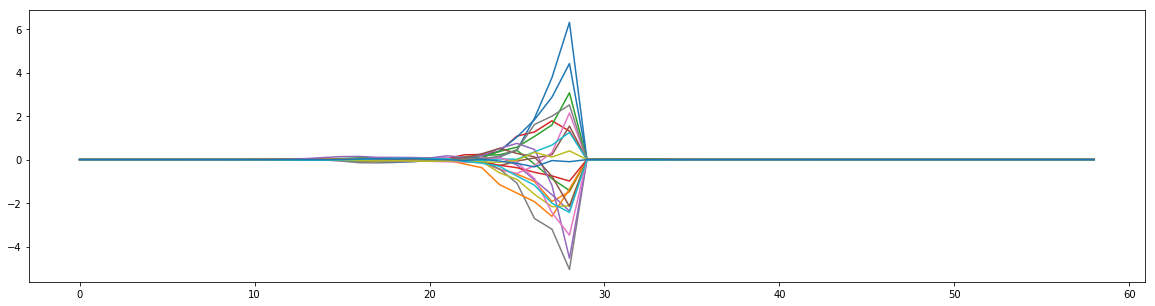

In [84]:
total = np.zeros((2*window + 1, 21))
for pos in range(int(sum(mask[seq]))):
    if pos > window:
        init = pos - window
        total[:window] += np.sum(saliencies[:,pos,seq,init:pos,:], axis=0)
    elif pos != 0:
        init = window - pos
        total[init:window] += np.sum(saliencies[:,pos,seq,0:pos,:], axis=0)
        
    total[window] = np.sum(saliencies[:,pos,seq,pos,:], axis=0)
    
    if pos + window + 1 <= sum(mask[seq]):
        end = pos + window + 1
        total[window+1:] = np.sum(saliencies[:,pos,seq,pos+1:end,:], axis=0)
    elif pos != int(sum(mask[seq])):
        end = int(sum(mask[seq]))
        total[window+1:-(pos+window+1-end)] = np.sum(saliencies[:,pos,seq,pos+1:end,:], axis=0)

fig, ax = plt.subplots(figsize=(20,5))
for el in range(21):
    plt.plot(total[:,el])

In [80]:
total.shape

(59, 21)

In [72]:
print total.shape
print init

(59,)
120


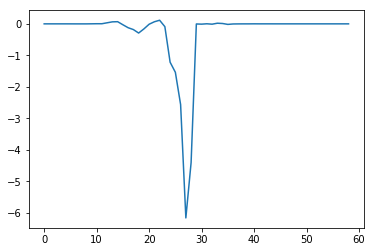

In [74]:
plt.plot(total)

In [57]:
sum(mask[0])

315.0

In [44]:
first_seq=1
num_seqs=20
"saliencies"+str(first_seq)+"-"+str(first_seq+num_seqs)+".pkl"

'saliencies1-21.pkl'

### Compute gradients

In [53]:
#weights = model.trainable_weights # weight tensors
gradients = theano.gradient.grad(model.outputs[0][seq,pos,7], wrt=[model.inputs[0], model.inputs[1]])
gradients = theano.gradient.jacobian(model.outputs[0][seq,pos,5].flatten(), wrt=[model.inputs[0], model.inputs[1]])
#gradients = K.gradients(model.predict, model.inputs)
#gradients = K.gradients(model.total_loss, model.inputs) # gradient tensors
#input_tensors = model.inputs + model.sample_weights + model.targets + [K.learning_phase()]
#get_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [106]:
get_gradients = K.function(inputs=[model.inputs[0], model.inputs[1], K.learning_phase()], outputs=gradients)

In [109]:
inputs = [X_test_am[seq,...], X_test_pssm[seq,...], 0]
inputs = [inputs[0][None,...], inputs[1][None,...], inputs[2]]
grads = get_gradients(inputs)
grads = np.array(grads)

(2, 1, 700, 21)

In [94]:
grads[:,seq,init:end,:]

array([[[-1.30143346e-12, -8.42253264e-12, -1.02235729e-11, ...,
         -4.55312264e-12,  3.60481393e-12,  1.45631705e-12],
        [ 8.03531408e-11, -1.39723259e-12,  5.40718893e-11, ...,
          7.32759756e-11,  3.53763997e-11, -6.99510762e-12],
        [-1.08706572e-10, -1.86981541e-10, -3.23495813e-10, ...,
         -3.27680272e-10,  1.90031033e-10,  6.79268100e-11],
        ...,
        [ 2.25766129e-13, -5.01347390e-13,  5.91065608e-13, ...,
          2.65183654e-13, -2.47494083e-14, -2.01070199e-13],
        [ 5.14729149e-14,  9.01710686e-14,  1.03888347e-13, ...,
          1.73511243e-14, -4.54712290e-14, -8.17424199e-14],
        [ 6.72787047e-15, -6.02380482e-15,  1.18631343e-14, ...,
          6.08384802e-15,  2.71091116e-15,  9.20786139e-15]],

       [[ 1.54587725e-12,  3.38451923e-12,  8.48274055e-12, ...,
         -1.50026415e-11, -3.45101660e-12, -8.26000780e-14],
        [ 2.44336253e-11, -1.18907606e-10,  8.05771075e-12, ...,
          6.94067156e-12,  6.10600320e

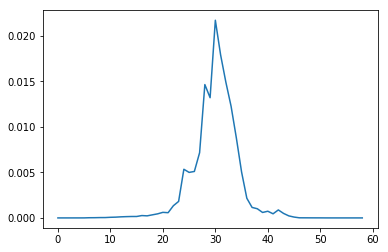

In [127]:
plt.plot(np.sum(np.sum(abs(grads[:,0,init:end,:]), axis=2), axis=0)) # Aminoacid importance
#plt.plot(grads[1,0,pos,:])

In [123]:
abs(grads[:,seq,init:end,:]).shape

(2, 59, 21)

In [50]:
import pickle
with open(("test_saliency/saliencies.pkl"), "r") as f:
    saliencies = pickle.load(f)

ValueError: unsupported pickle protocol: 4

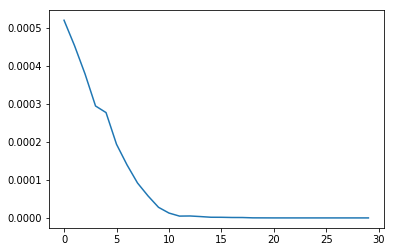

In [11]:
plt.plot(saliencies[0,0]["grads"])

# Analyze sequence predictions

In [4]:
with open("test_saliency/predictions.pkl", "rb") as f:
    predictions = pickle.load(f)
    print("Predictions shape", predictions.shape)

In [56]:
from test_saliency.saliency import load_data
split_value = 5534

X_am, X_pssm, mask, labels = load_data("test_saliency/")
print("X_am shape", X_am.shape, "X_pssm shape", X_pssm.shape, "mask shape", mask.shape, "labels shape",labels.shape)

Using Theano backend.


('X_am shape', (6048, 700, 21), 'X_pssm shape', (6048, 700, 21), 'mask shape', (6048, 700), 'labels shape', (6048, 700))


In [22]:
def calculate_seq_accuracy(predictions, labels):
    num_seq = len(predictions)
    seq_len = predictions.shape[1]

    seq_acc = np.zeros(num_seq)
    for seq in range(num_seq):
        for pos in range(seq_len):
            if mask[seq,pos]:
                if labels_test[seq, pos] == np.argmax(predictions[seq, pos]):
                    seq_acc[seq] += 1
            else:
                break

        seq_acc[seq] /= np.sum(mask[seq])
    
    return seq_acc

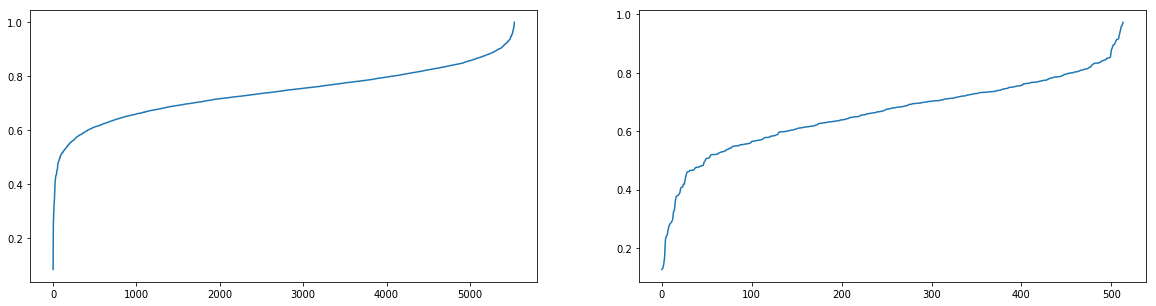

In [23]:
seq_acc = calculate_seq_accuracy(predictions, labels_test)

### Per-sequence accuracy plots

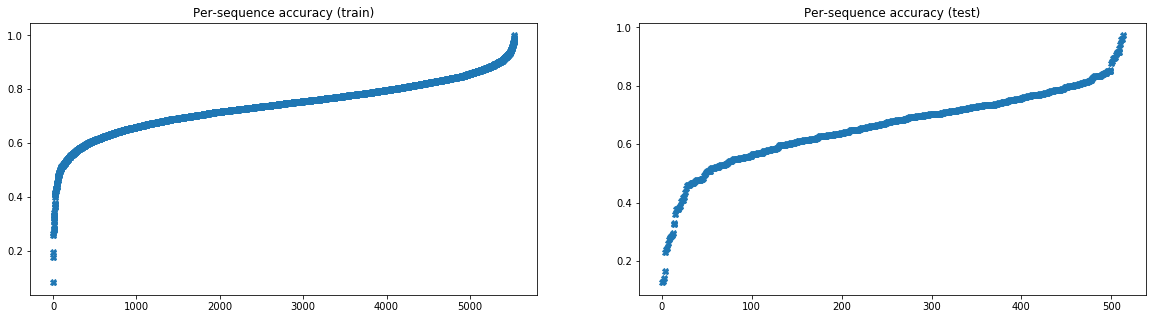

In [28]:
fig,ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(sorted(seq_acc_train), marker="X", linewidth=0)
ax[0].set(title='Per-sequence accuracy (train)')

ax[1].plot(sorted(seq_acc_test), marker="X", linewidth=0)
ax[1].set(title='Per-sequence accuracy (test)')

### Accuracy-size plots

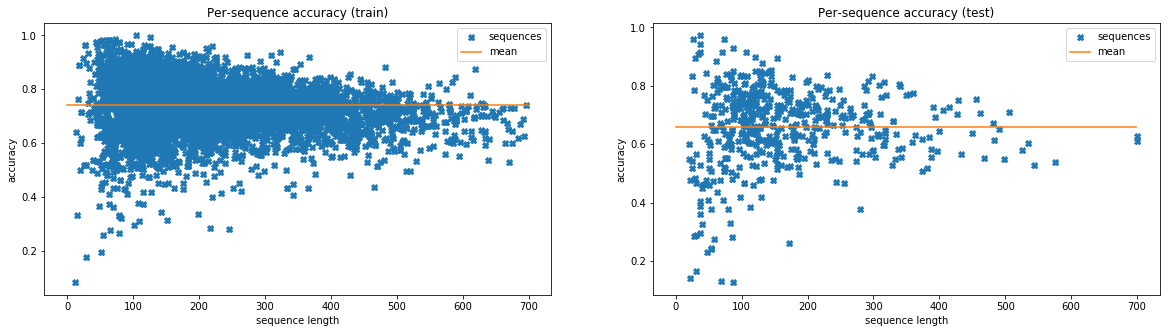

In [49]:
fig,ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(np.sum(mask[:split_value], axis=1), seq_acc_train, marker="X", linewidth=0, label="sequences")
ax[0].plot(np.mean(seq_acc_train)*np.ones(seq_len), label="mean")
ax[0].set(title='Per-sequence accuracy (train)', ylabel="accuracy", xlabel="sequence length")
ax[0].legend()

ax[1].plot(np.sum(mask[split_value:], axis=1), seq_acc_test, marker="X", linewidth=0, label="sequences")
ax[1].plot(np.mean(seq_acc_test)*np.ones(seq_len), label="mean")
ax[1].set(title='Per-sequence accuracy (test)', ylabel="accuracy", xlabel="sequence length")
ax[1].legend()